---
# Model S - Baseline Model with Adam Optimizer
- **32 x 32 x 3** Image size.
- **32** Batch size.
- **Stochastic Gradient Descent (SGD) optimizer**.
- **0.001 Initial Learning rate**.
- **Sparse Categorical Cross-Entropy** loss function.
- **Reduce Learning Rate on Plateau** callback.
- **Early Stopping** callback.
- **Model Checkpoint** callback.
- 2 **Convolutional** layers with **32** filters and **64** filters.
- 2 **MaxPooling** layers with **2 x 2** pool size.
- **3 x 3** Convolutional kernel size.
- **5 x 5 x 256** Tensor before flatten.
- **128** Dense layer units.
- **0.5** Dropout rate.
- **10** Output units.
- **30** Epochs.

---
#### Imports and Setup

In [59]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)
import matplotlib.pyplot as plt
import pickle
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import callbacks, layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay ,accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

TensorFlow version: 2.15.0


---
#### Group Datasets

In [60]:
train_dirs = ['../data/train1', '../data/train3', '../data/train4', '../data/train5']
validation_dir = '../data/train2'
test_dir = '../data/test'

---
#### Create Datasets

In [61]:
IMG_SIZE = 32
BATCH_SIZE = 32
NUM_CLASSES = 10

train_datasets = [image_dataset_from_directory(directory, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE) for directory in train_dirs]

train_dataset = train_datasets[0]
for dataset in train_datasets[1:]:
    train_dataset = train_dataset.concatenate(dataset)

train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = image_dataset_from_directory(validation_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = image_dataset_from_directory(test_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

class_names = train_datasets[0].class_names

for data_batch, labels_batch in train_dataset.take(1):
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)

Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
data batch shape: (32, 32, 32, 3)
labels batch shape: (32,)


- We define the image size of 32 x 32 x 3, batch size of 32 and create an array with the label's names.  
- We create the train dataset by concatenating them, we **shuffle** the samples before each epoch and **prefetch** them to memory.  
- We do the same for the validation and test dataset except shuffling which is unnecessary.

---
#### Model Architecture

In [62]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                     

---
#### Model Compilation

In [63]:
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
loss_function = keras.losses.SparseCategoricalCrossentropy()

lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
save_best_model = callbacks.ModelCheckpoint(filepath='../models/01_model_s_baseline_model_adam.keras', save_best_only=True, monitor='val_loss', verbose=1)

callbacks = [lr_scheduler, early_stopping, save_best_model]

model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

---
#### Model Training

In [64]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=30,
                    callbacks=callbacks)

Epoch 1/30
1247/1252 [============================>.] - ETA: 0s - loss: 1.6808 - accuracy: 0.3763
Epoch 1: val_loss improved from inf to 1.35127, saving model to ../models/01_model_s_baseline_model_adam.keras
1252/1252 [==============================] - 10s 7ms/step - loss: 1.6794 - accuracy: 0.3769 - val_loss: 1.3513 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 2/30
1250/1252 [============================>.] - ETA: 0s - loss: 1.3762 - accuracy: 0.5052
Epoch 2: val_loss improved from 1.35127 to 1.20591, saving model to ../models/01_model_s_baseline_model_adam.keras
1252/1252 [==============================] - 9s 7ms/step - loss: 1.3760 - accuracy: 0.5052 - val_loss: 1.2059 - val_accuracy: 0.5671 - lr: 0.0010
Epoch 3/30
1246/1252 [============================>.] - ETA: 0s - loss: 1.2401 - accuracy: 0.5596
Epoch 3: val_loss improved from 1.20591 to 1.10338, saving model to ../models/01_model_s_baseline_model_adam.keras
1252/1252 [==============================] - 9s 7ms/step - loss: 1.2395 

---
#### Save Model History

In [65]:
with open("../history/01_model_s_baseline_model_adam.pkl", "wb") as file:
    pickle.dump(history.history, file)

---
#### Model Evaluation

In [66]:
val_loss, val_acc = model.evaluate(validation_dataset)
print(f'Model Validation Loss: {val_loss:.2f}')
print(f'Model Validation Accuracy: {val_acc:.2%}')

313/313 [==============================] - 1s 2ms/step - loss: 0.8791 - accuracy: 0.7009
Model Validation Loss: 0.88
Model Validation Accuracy: 70.09%


---
#### Model Training Visualization

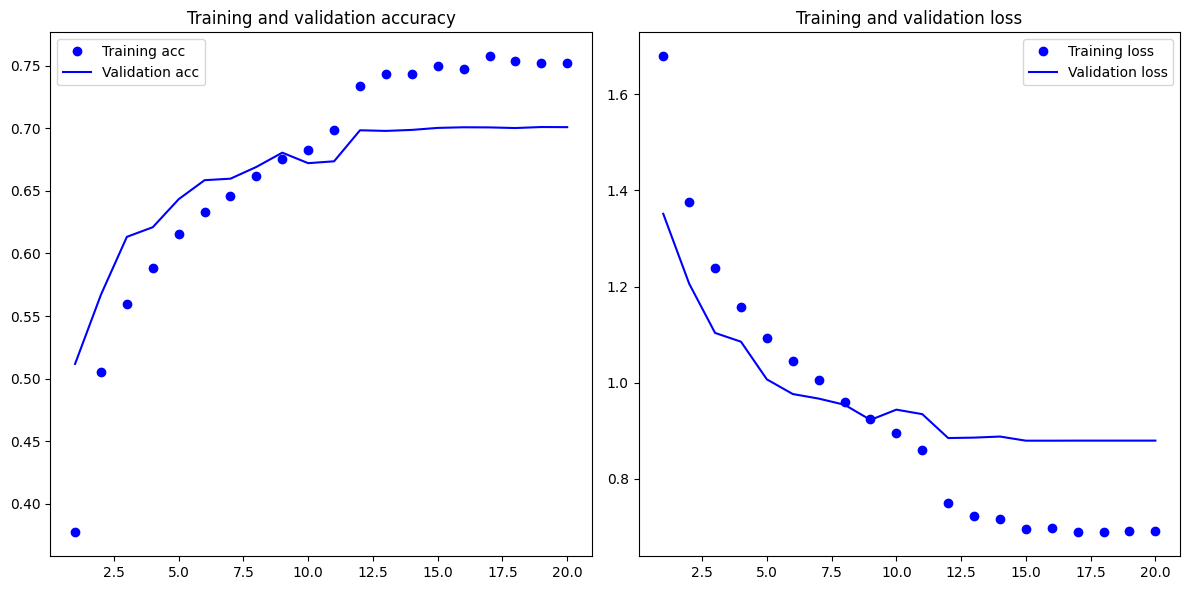

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()
plt.show()

- Analyzing the training and validation, accuracy and loss over the epochs:
    - We see that the model begins overfitting after the **12th** epoch. The validation accuracy stops improving significantly while the training accuracy keeps improving.
    - The validation loss stops improving significantly after the **11th** epoch while the training loss keeps improving.
    - The best model, based on validation loss, is saved on the **16th** epoch.
    - The training stops after the **20th** epoch because of the **Early Stopping** callback.

---
#### Model Testing

In [68]:
test_labels = []
test_predictions = []
test_probabilities = []

for images, labels in test_dataset:
    test_labels.extend(labels.numpy())
    predictions = model.predict(images)
    test_predictions.extend(np.argmax(predictions, axis=-1))
    test_probabilities.extend(predictions)

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)
test_probabilities = np.array(test_probabilities)

1/1 [==============================] - 0s 41ms/step


---
#### Confusion Matrix

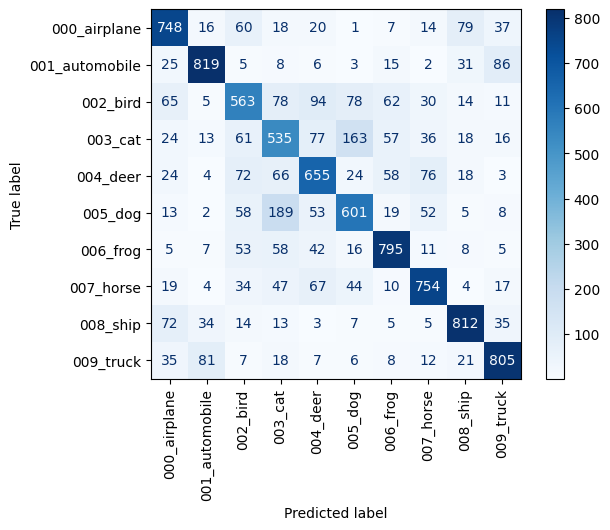

In [69]:
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.show()

- Looking at the confusion matrix, we see that the model has some trouble distinguishing between some categories.  
    - The model has a hard time distinguishing the categories 003_cat and 005_dog.  
    - The model has a below average performance on the categories 002_bird, in which we see a very high false positive rate.
    - The model also has a hard time distinguishing between some other categories but the error is not as significant.  
    - The model has an above average performance on the categories 001_automobile, 006_frog, 008_ship and 009_truck.

---
#### ROC Curve Analysis

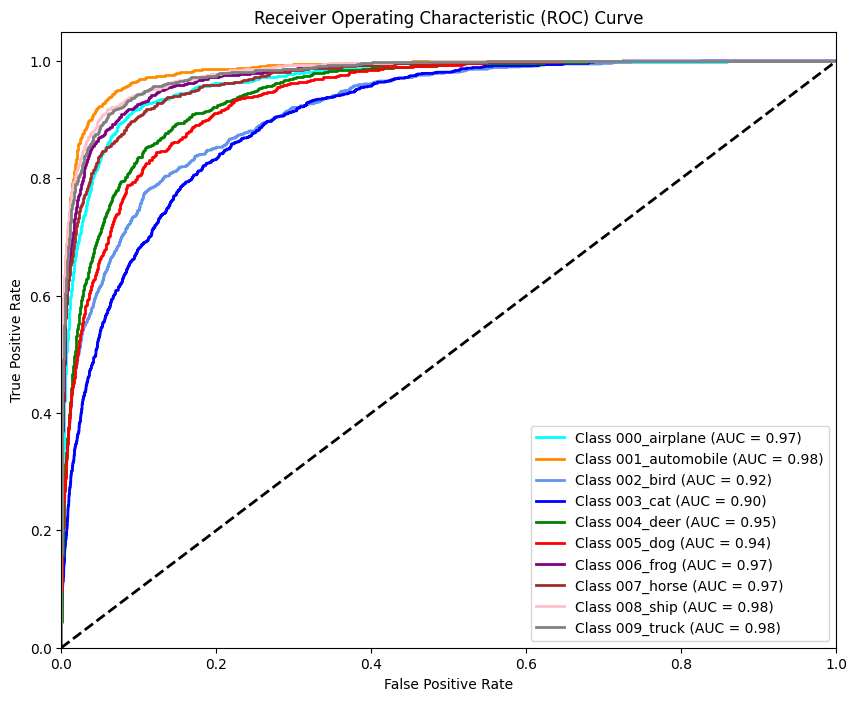

In [70]:
test_labels_bin = label_binarize(test_labels, classes=range(NUM_CLASSES))

false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(test_labels_bin[:, i], test_probabilities[:, i])
    roc_auc[i] = auc(false_positive_rate[i], true_positive_rate[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'green', 'red', 'purple', 'brown', 'pink', 'grey'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(false_positive_rate[i], true_positive_rate[i], color=color, lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

- Looking at the ROC curve:
    - We see that the model has a mediocre performance on the ROC curve for most categories.  
    - The categories 003_cat, 002_bird, 005_dog and 004_deer have the worst AUC (Area Under Curve) performance.
    - The categories 001_automobile, 008_ship and 009_truck have the best AUC performance.
    - **A perfect AUC of 1.0 would mean that the model classifies all true positives and true negatives correctly**.

---
#### Performance Metrics
- **Accuracy** is the proportion of correctly predicted instances out of the total instances.  
- **Precision** is the ratio of true positive predictions to the total predicted positives. Macro precision calculates this for each class independently and then averages them.  
- **Weighted precision** calculates the precision for each class, then averages them, weighted by the number of true instances for each class.  
- **Recall** is the ratio of true positive predictions to the total actual positives. Macro recall calculates this for each class independently and then averages them.  
- **Weighted recall** calculates the recall for each class, then averages them, weighted by the number of true instances for each class.  
- The **F1-score** is the harmonic mean of precision and recall. Macro F1-score calculates this for each class independently and then averages them.  
- **Weighted F1-score** calculates the F1-score for each class, then averages them, weighted by the number of true instances for each class.

In [71]:
acc = accuracy_score(y_true =  test_labels, y_pred = test_predictions)
print(f'Accuracy : {np.round(acc*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Precision - Macro: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Recall - Macro: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'F1-score - Macro: {np.round(f1*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Precision - Weighted: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Recall - Weighted: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'F1-score - Weighted: {np.round(f1*100,2)}%')

Accuracy : 70.87%
Precision - Macro: 70.8%
Recall - Macro: 70.87%
F1-score - Macro: 70.81%
Precision - Weighted: 70.8%
Recall - Weighted: 70.87%
F1-score - Weighted: 70.81%


- **Since the dataset is balanced, the **MACRO** average is a good metric to evaluate the model.**

# Conclusion
### Summary
- In this notebook:
    - We have trained a model with no data augmentation, using the Sparse Categorical Cross-Entropy loss function and the **SGD optimizer**.  
    - We experimented with various architectures, and we settled for the simplicity of this one: 
    - Different learning rates were tested; we settled for the Reduce Learning Rate on Plateau callback with a starting value of 0.001. 
    - Various batch sizes were explored; 64 was the most effective. 
    - Multiple optimizers were evaluated; we settled for RMSProp for this model.
    - Several regularization values were tried; this combination provided the best results.
    - Different dropout rates were assessed; this rate provided the best results.
    - Various epoch counts were tested; 30 epochs were optimal.
    - Different kernel sizes were considered; this size was the most effective.
    - Various numbers of kernels were tested; this configuration was a combination of simple and effective.
    - Different numbers of MaxPooling layers were evaluated; this number was the most effective.
    - We opted to add Batch Normalization after each convolutional layer.
    - We used L1 and L2 regularization on both convolutional and dense layers.
    - Dropout was applied to the dense layers.
    - The model showed some difficulty distinguishing between certain categories, particularly cats and dogs.
    - Overfitting was observed after **15 epochs**, but the best model was saved at the **20th epoch**.
    - We evaluated the model using a confusion matrix to analyze its performance on each category.
    - We evaluated the model using ROC curves for a deeper performance analysis.
    - **The model achieved an accuracy of 81.83% on the test set**.

### Future Work
- In the next phase, we will:
    - For the next notebook, we will retain the architecture, but we will experiment with a different optimizer, tweak with data augmentation and see if we can improve the model's performance.